# Подготовка данных

1) Загрузите данные.
1) Разделите на признаки (X) и цель (y = prepared_on_time).
1) Разделите на обучающую и тестовую выборки в пропорции 80% / 20% (зафиксируйте random_state).

## Загрузите данные

In [9]:
import sys
import pandas as pd

df = None

# Загрузка данных (Colab / локально)
if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    drive.mount("/content/drive")
    df = pd.read_csv("/content/drive/MyDrive/module_7/data/preprocessed_orders.csv")
else:
    df = pd.read_csv("data/preprocessed_orders.csv")

df.head()


,Unnamed: 0,store_id,order_id,product_id,price,profit,delivery_distance,planned_prep_time,region_id,order_price,items_count,prepared_on_time
0,0,5014.0,20562761.0,41.0,7.04,45.504,2205.0,15.0,683.0,30.49,2.0,1.0
1,1,5014.0,20562761.0,31.0,23.45,45.504,2205.0,15.0,683.0,30.49,2.0,1.0
2,2,3856.0,20562753.0,7.0,51.94,30.336,1368.0,10.0,683.0,240.78,2.0,1.0
3,3,3856.0,20562753.0,4.0,98.96,30.336,1368.0,10.0,683.0,240.78,2.0,1.0
4,4,10825.0,20562723.0,12.0,85.99,43.608,459.0,20.0,683.0,85.99,1.0,1.0


In [10]:
df.shape


(15264, 12)

In [11]:
if not df["order_id"].is_unique:
    print("order_id не уникальны")
    df = (
        df.groupby("order_id")
        .agg(
            {
                "store_id": "first",
                "delivery_distance": "first",
                "planned_prep_time": "first",
                "region_id": "first",
                "order_price": "first",
                "items_count": "first",
                "prepared_on_time": "first",
                "profit": "sum",
            }
        )
        .reset_index()
    )
    print("После агрегирования размерность:", df.shape)
else:
    print("order_id уникальны")


order_id не уникальны
После агрегирования размерность: (5959, 9)


In [12]:
required_columns = [
    "store_id",
    "order_price",
    "profit",
    "delivery_distance",
    "planned_prep_time",
    "region_id",
    "items_count",
    "prepared_on_time",
]
if not set(required_columns).issubset(df.columns):
    print("Отсутствуют столбцы:", set(required_columns) - set(df.columns))
else:
    print("Все обязательные столбцы присутствуют.")


Все обязательные столбцы присутствуют.


In [13]:
df[required_columns].info()
print(df[required_columns].isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5959 entries, 0 to 5958
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   store_id           5959 non-null   float64
 1   order_price        5959 non-null   float64
 2   profit             5959 non-null   float64
 3   delivery_distance  5959 non-null   float64
 4   planned_prep_time  5959 non-null   float64
 5   region_id          5959 non-null   float64
 6   items_count        5959 non-null   float64
 7   prepared_on_time   5959 non-null   float64
dtypes: float64(8)
memory usage: 372.6 KB
store_id             0
order_price          0
profit               0
delivery_distance    0
planned_prep_time    0
region_id            0
items_count          0
prepared_on_time     0
dtype: int64


## Разделите на признаки (X) и цель (y = prepared_on_time)

In [14]:
feature_cols = [
    "store_id",
    "order_price",
    "profit",
    "delivery_distance",
    "planned_prep_time",
    "region_id",
    "items_count",
]

X = df[feature_cols]
y = df["prepared_on_time"]


## Разделите на обучающую и тестовую выборки в пропорции 80%/20% (зафиксируйте random_state).

In [15]:
from sklearn.model_selection import train_test_split

TEST_SIZE: float = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)


In [16]:
print(f"""########################################
Размер обучающей выборки: {X_train.shape}
Размер тестовой выборки: {X_test.shape}
Доля класса 1 в y_train: {y_train.mean() * 100:.2f}%
Доля класса 1 в y_test: {y_test.mean() * 100:.2f}%
########################################""")


########################################
Размер обучающей выборки: (4767, 7)
Размер тестовой выборки: (1192, 7)
Доля класса 1 в y_train: 83.55%
Доля класса 1 в y_test: 83.56%
########################################


# Классификация: RandomForestClassifier

1) Подберите гиперпараметры с помощью GridSearchCV (кросс-валидация):
    - n_estimators (количество деревьев).
    - max_depth (глубина).
    - criterion.
    - min_samples_leaf.
2) Оцените модель на тестовой выборке; выведите: accuracy, precision, recall, f1-score и classification_report


## Подберите гиперпараметры с помощью GridSearchCV (кросс-валидация)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [None, 5, 10],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [1, 3],
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid_search.best_params_)
print(f"Лучший результат (accuracy): {grid_search.best_score_:.4f}")


Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 50}
Лучший результат (accuracy): 0.8355


## Оцените модель на тестовой выборке; выведите: accuracy, precision, recall, f1-score и classification_report

In [18]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import (  # noqa: E402
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8356
Precision: 0.8356
Recall: 1.0000
F1-score: 0.9104
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       196
         1.0       0.84      1.00      0.91       996

    accuracy                           0.84      1192
   macro avg       0.42      0.50      0.46      1192
weighted avg       0.70      0.84      0.76      1192



d:\Programming\Python\it-lms\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programming\Python\it-lms\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programming\Python\it-lms\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

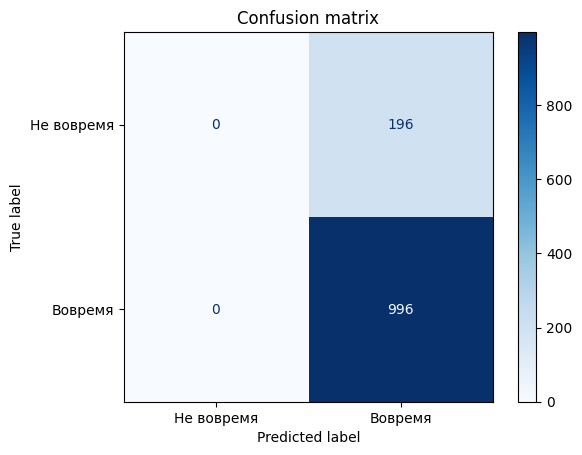

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test, display_labels=["Не вовремя", "Вовремя"], cmap=plt.cm.Blues
)
plt.title("Confusion matrix")
plt.show()


# Анализ важности признаков

1) Постройте график feature_importances_.
2) Напишите выводы о значимости признаков.



## Постройте график feature_importances_

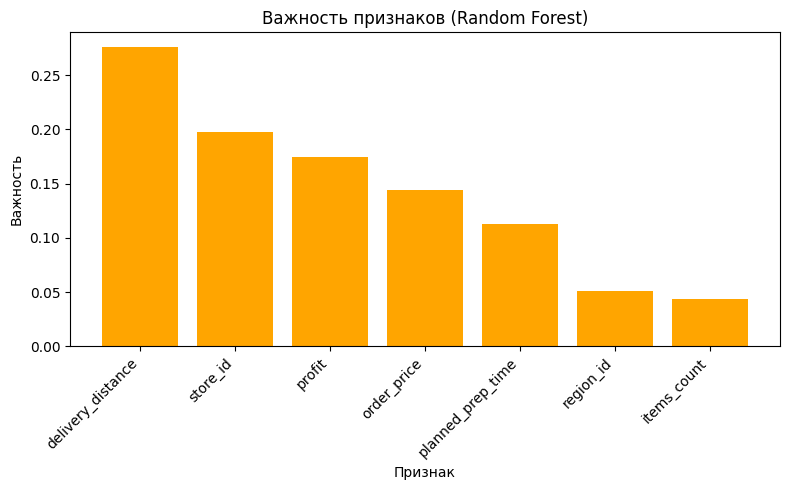

In [20]:
import numpy as np

importances = best_rf.feature_importances_
feature_names = feature_cols
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], color="orange")
plt.xticks(
    range(len(importances)),
    [feature_names[i] for i in indices],
    rotation=45,
    ha="right",
)

plt.xlabel("Признак")
plt.ylabel("Важность")
plt.title("Важность признаков (Random Forest)")
plt.tight_layout()
plt.show()


## Напишите выводы о значимости признаков

In [23]:
print("""
Выводы о значимости признаков:
1) Наиболее важные признаки:
  - `delivery_distance` — влияет на своевременность доставки; логично, чем дальше, тем выше риск опоздания.
  - `order_price` и `profit` — могут коррелировать с размером и сложностью заказа (чем дороже, тем дольше готовится).
2) Умеренное влияние:
  - `planned_prep_time` — разумно, что запланированное время влияет на факт своевременной готовности.
3) Менее значимые:
  - `items_count`, `region_id`, `store_id` — влияют меньше всего.
Ключевые факторы связаны с логистикой и размером заказа, а не с логистикой или числом позиций напрямую.
""")



Выводы о значимости признаков:
1) Наиболее важные признаки:
  - `delivery_distance` — влияет на своевременность доставки; логично, чем дальше, тем выше риск опоздания.
  - `order_price` и `profit` — могут коррелировать с размером и сложностью заказа (чем дороже, тем дольше готовится).
2) Умеренное влияние:
  - `planned_prep_time` — разумно, что запланированное время влияет на факт своевременной готовности.
3) Менее значимые:
  - `items_count`, `region_id`, `store_id` — влияют меньше всего.
Ключевые факторы связаны с логистикой и размером заказа, а не с логистикой или числом позиций напрямую.



## 

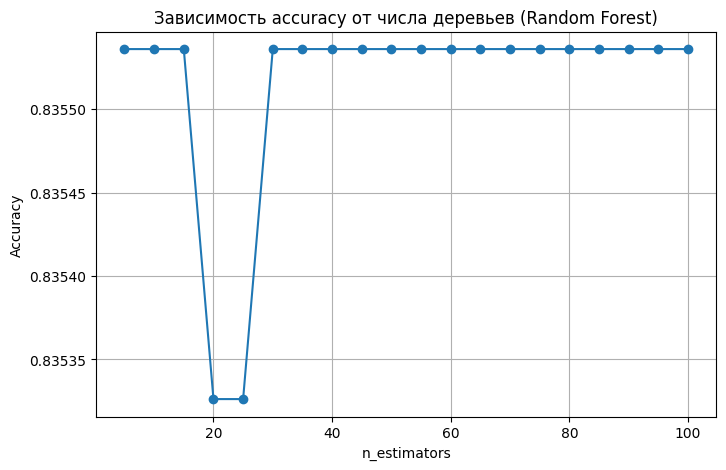

In [24]:
from sklearn.model_selection import cross_val_score

best_n = grid_search.best_params_["n_estimators"]
n_values = [n for n in range(best_n - 50, best_n + 51, 5) if n >= 1]

cv_scores = [
    cross_val_score(
        RandomForestClassifier(
            n_estimators=n,
            max_depth=grid_search.best_params_["max_depth"],
            criterion=grid_search.best_params_["criterion"],
            min_samples_leaf=grid_search.best_params_["min_samples_leaf"],
            random_state=RANDOM_STATE,
        ),
        X_train,
        y_train,
        cv=5,
    ).mean()
    for n in n_values
]

plt.figure(figsize=(8, 5))
plt.plot(n_values, cv_scores, marker="o")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Зависимость accuracy от числа деревьев (Random Forest)")
plt.grid(True)
plt.show()
